In [1]:
import re
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from tqdm import tqdm
from nltk.corpus import stopwords
stopwordEn = stopwords.words('english')
import pickle

In [2]:
!ls data_0323-29/

df_0325_tweets_8.pickle   df_0328_tweets_11.pickle
df_0326_tweets_8.pickle   df_0329_tweets_11.pickle
df_0326_tweets_9.pickle   tweets_hashtags_dict_0329.pickle
df_0327_tweets_10.pickle  tweets_words_dict_0329.pickle
df_0327_tweets_9.pickle   tweets_words_dict_2G_0329.pickle
df_0328_tweets_10.pickle


In [4]:
# get one-week news data
FILE = '0328'
with open('./data_0323-29/df_{}_tweets_11.pickle'.format(FILE), 'rb') as handle:
    df_1 = pickle.load(handle)
with open('./data_0323-29/df_{}_tweets_10.pickle'.format(FILE), 'rb') as handle:
    df_2 = pickle.load(handle)
df = pd.concat([df_2, df_1])
df.shape

(834611, 3)

In [7]:
df.head()

,created_at,full_text,re_full_text
0,Sat Mar 28 00:00:00 +0000 2020,"RT @2LarryJohnson7: People who don’t know me, ...","People who don’t know me, trying to gauge my p..."
1,Sat Mar 28 00:00:00 +0000 2020,@elonmusk 1|Take a drop of blood and drop it o...,
2,Sat Mar 28 00:00:00 +0000 2020,"Bishop's Corona Diaries\nDay 10 - Friday, Marc...",
3,Sat Mar 28 00:00:00 +0000 2020,PLEASEEEEE🙏🏾😫 https://t.co/pBL3JrFP5E,
4,Sat Mar 28 00:00:00 +0000 2020,RT @Blaaq_ie: Make Corona Virus your new Crush...,Make Corona Virus your new Crush so you can ne...


In [8]:
full_texts = df[df['re_full_text']!='']['re_full_text'] # 转发的原文
len(full_texts),len(full_texts.unique()) #转发的原推数

(566148, 61787)

In [9]:
full_texts_orig = df[df['re_full_text']=='']['full_text'] #原创的且未在这个时间段被转发过
len(full_texts_orig),len(full_texts_orig.unique()) #大部分原创推特都没有重复

(268463, 266336)

In [10]:
full_texts_all = pd.concat([full_texts,full_texts_orig])
len(full_texts_all),len(full_texts_all.unique())

(834611, 289814)

# Multiprocessing

In [12]:
import multiprocessing as mp
import numpy as np
import time
print('CPU numbers:',mp.cpu_count())
def _apply_df(args):
    df, func, kwargs = args
    return df.apply(func, **kwargs)

def apply_by_multiprocessing(df, func, **kwargs):
#     print(kwargs)
    workers = kwargs.pop('workers')
    pool = mp.Pool(processes=workers)
    result = pool.map(_apply_df, [(d, func, kwargs) for d in np.array_split(df, workers)])
    pool.close()
    return pd.concat(list(result))
#apply_by_multiprocessing(fullset['Text'], process_text, workers=cores)

CPU numbers: 32


# Word Frequency

In [13]:
#multiprocessing method
def processText(text):
    tokens = word_tokenize(text)
    return [i for i in tokens if i not in stopwordEn and i.isalpha()]

all_words = []
s_py = time.time()
for i in apply_by_multiprocessing(full_texts_all, processText, workers=32):
    all_words.extend(i)
print("programme:",time.time()-s_py)

programme: 40.17736840248108


In [14]:
words_dict = nltk.FreqDist(all_words)
len(all_words),len(words_dict)

(13641702, 224181)

# Hash Tags

In [15]:
all_hashtags = [] 
for text in tqdm(full_texts_all):
    tags = re.findall('#(.*?) ',text)
    all_hashtags.extend(tags)

100%|██████████| 834611/834611 [00:02<00:00, 395428.72it/s]


In [16]:
hashtags_dict = nltk.FreqDist(all_hashtags)
len(all_hashtags), len(hashtags_dict)

(483232, 39522)

In [17]:
with open('./data_0323-29/tweets_words_dict_{}.pickle'.format(FILE), 'wb') as handle:
    pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('./data_0323-29/tweets_hashtags_dict_{}.pickle'.format(FILE), 'wb') as handle:
    pickle.dump(hashtags_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Word clouds

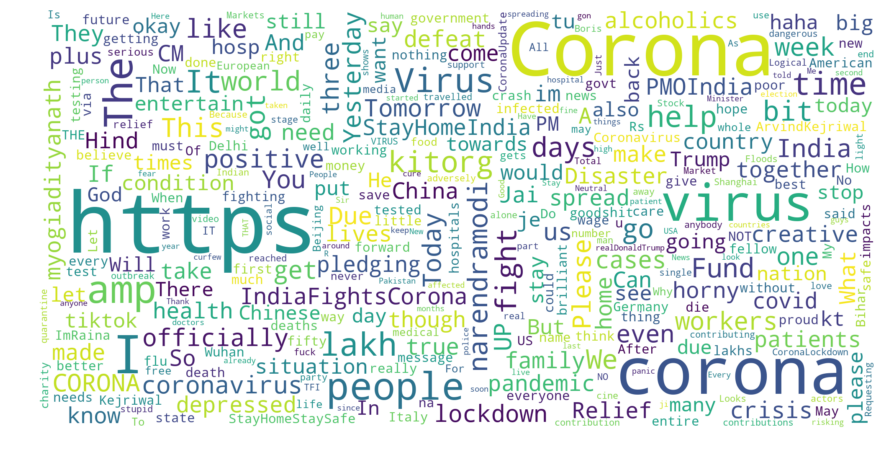

In [18]:
# tags cloud (with retweets)
# https://www.datacamp.com/community/tutorials/wordcloud-python
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# % matplotlib inline

wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=1000, background_color="white").generate_from_frequencies(words_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

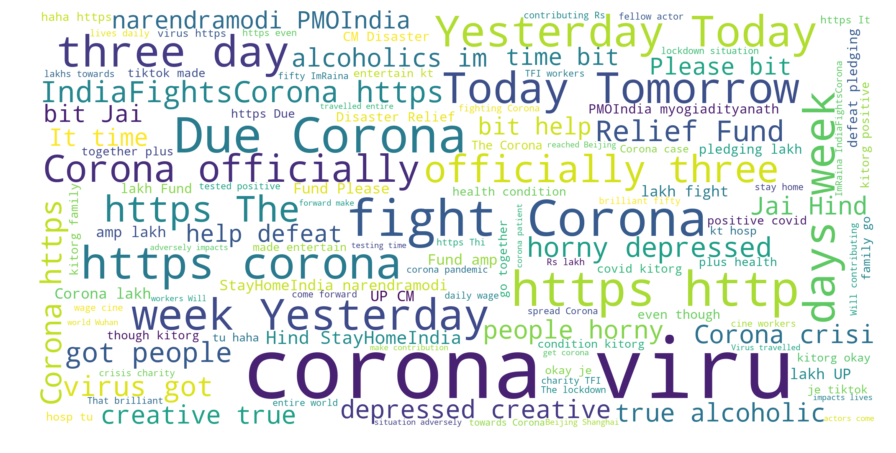

In [19]:
# vocabulary word cloud 2-gram 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# % matplotlib inline

wordcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=18, max_words=1000, background_color="white").generate(' '.join(all_words))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
with open('./data_0323-29/tweets_words_dict_2G_{}.pickle'.format(FILE),'wb') as handle:
    pickle.dump(wordcloud.words_, handle)

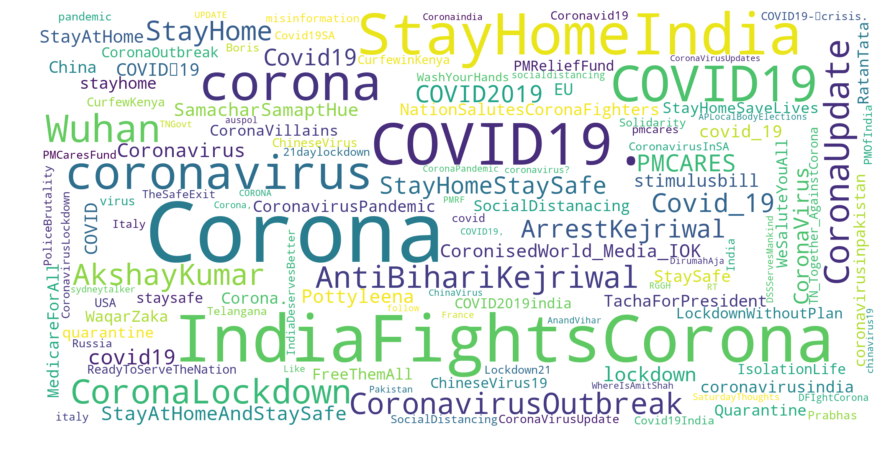

In [21]:
tagcloud = WordCloud(max_font_size=200, width=2000,height=1000, min_font_size=20, max_words=1000, background_color="white").generate_from_frequencies(hashtags_dict)
plt.figure(figsize=(15,8))
plt.imshow(tagcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Topic Modelling

In [32]:
from nltk.corpus import wordnet
# nltk.download('wordnet')
# def prepare_text_for_lda(word):
#     if word not in stopwordEn and word.isalpha():
#         lemma = wordnet.morphy(word)
#         if lemma is not None:
#             return lemma
#         else:
#             return word
def prepare_lda(t):
    tokens = []
    for word in word_tokenize(t):
        if word not in stopwordEn and word.isalpha():
            lemma = wordnet.morphy(word)
            if lemma is not None:
                tokens.append(lemma)
            else:
                tokens.append(word)
    return tokens
s_py = time.time()
text_data = apply_by_multiprocessing(df['text'], prepare_lda, workers=32)
print("programme:",time.time()-s_py)

programme: 105.74430346488953


In [33]:
from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = apply_by_multiprocessing(pd.Series(text_data), dictionary.doc2bow, workers=32)
# corpus = [dictionary.doc2bow(text) for text in text_data]

In [2]:
import gensim
NUM_TOPICS = 12
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
# ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=3)
for topic in topics:
    print(topic)

In [1]:
# 3-word topics
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)